In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CNN

/content/drive/MyDrive/CNN


In [3]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline 


In [4]:
data = pd.read_csv("./data/icml_face_data.csv")

data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
data.isnull()             # null 확인
data.isnull().sum()       # null 갯수 확인

emotion    0
 Usage     0
 pixels    0
dtype: int64

In [7]:
names = np.array(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

Text(0.5, 1.0, 'PublicTest')

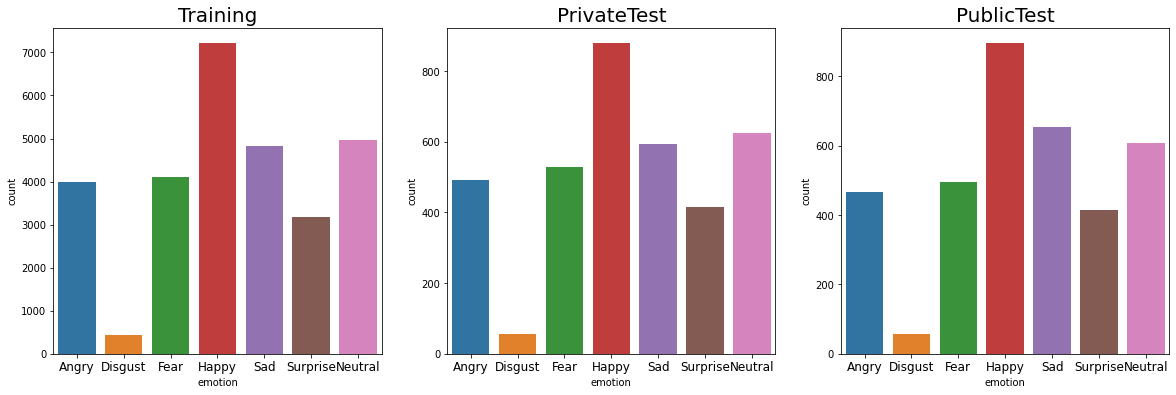

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
ax1 = sns.countplot(data = data[data[' Usage'] == 'Training'], x = 'emotion')
ax1.set_xticklabels(names, size = 12)
ax1.set_title('Training', size = 20)

plt.subplot(1, 3, 2)
ax2 = sns.countplot(data = data[data[' Usage'] == 'PrivateTest'], x = 'emotion')
ax2.set_xticklabels(names, size = 12)
ax2.set_title('PrivateTest', size = 20)

plt.subplot(1, 3, 3)
ax3 = sns.countplot(data = data[data[' Usage'] == 'PublicTest'], x = 'emotion')
ax3.set_xticklabels(names, size = 12)
ax3.set_title('PublicTest', size = 20)

In [9]:
def pre_data(data):
    images = np.zeros(shape=(len(data[' pixels']), 48, 48))
    labels = np.array(data['emotion'])

    for i, row in enumerate(data[' pixels']):
        image = np.fromstring(row, dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        images[i] = image
    
    images = images.reshape((images.shape[0], 48, 48, 1))
    
    return images, labels


def pre_data_ohe(data):
    images, labels = pre_data(data)
    oh_labels = to_categorical(labels)
    return images, oh_labels



def show_images(images, labels, ncols, title):
    figure, ax = plt.subplots(figsize=(20, 3), nrows=1, ncols=ncols)
    images_plot = images.reshape((images.shape[0], 48, 48))
    for i in range(ncols):
        ax[i].imshow(images_plot[i], cmap='gray')
        label = labels[i].argmax()
        ax[i].set_title(names[int(label)])
        
    figure.suptitle(title, size=20, fontweight='bold')

In [10]:
train_images, train_labels = pre_data_ohe(data[data[' Usage'] == 'Training'])
val_images, val_labels = pre_data_ohe(data[data[' Usage'] == 'PrivateTest'])
test_images, test_labels = pre_data_ohe(data[data[' Usage'] == 'PublicTest'])

In [11]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)
(3589, 48, 48, 1) (3589, 7)


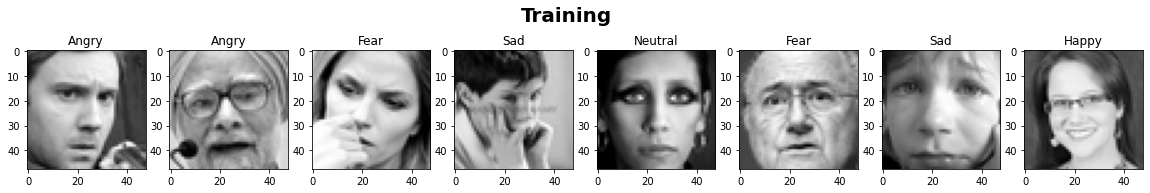

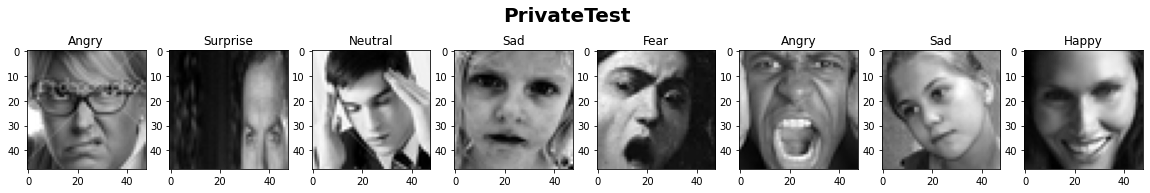

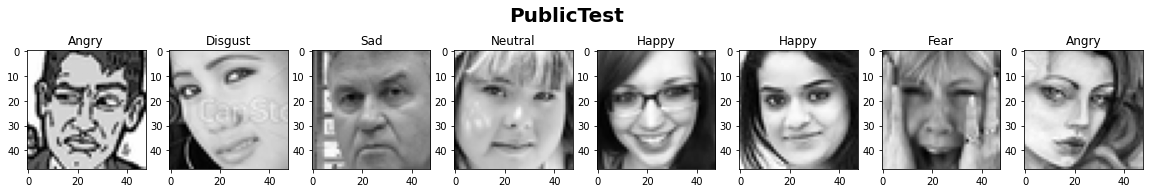

In [12]:
show_images(train_images[:8], train_labels[:8], 8, "Training")
show_images(val_images[:8], val_labels[:8], 8, 'PrivateTest')
show_images(test_images[:8], test_labels[:8], 8, 'PublicTest')

In [41]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=20, shear_range=0.2,
                                     horizontal_flip=True,
                                     rescale=1/255.0)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(train_images, train_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_labels, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
def create_model():
    input_tensor = Input(shape=(48, 48, 1))

    x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=2)(x)

    #x = Flatten(name='flatten')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.25)(x)
    x = Dense(256, activation='relu', name='fc1')(x)

    output = Dense(7, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    return model

In [43]:
model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_25 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_35 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_36 (Activation)   (None, 48, 48, 64)        0   

In [44]:
MODEL_DIR = './Facial_callback/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./Facial_callback/{val_loss:.4f}-{val_accuracy:.4f}.hdf5"

mcp_cb = ModelCheckpoint(filepath=modelpath, save_best_only=True, verbose=1)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_accuracy', patience=5)


history = model.fit_generator(flow_tr_gen, validation_data=flow_val_gen, 
                              epochs=30, 
                              steps_per_epoch=len(flow_tr_gen), validation_steps=len(flow_val_gen), 
                              callbacks=[mcp_cb, rlr_cb, ely_cb])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
898/898 [==============================] - 13s 14ms/step - loss: 1.7666 - accuracy: 0.2743 - val_loss: 2.5460 - val_accuracy: 0.2689

Epoch 00001: val_loss improved from inf to 2.54596, saving model to ./Facial_callback/2.5460-0.2689.hdf5
Epoch 2/30
898/898 [==============================] - 12s 13ms/step - loss: 1.4516 - accuracy: 0.4360 - val_loss: 2.2112 - val_accuracy: 0.1764

Epoch 00002: val_loss improved from 2.54596 to 2.21124, saving model to ./Facial_callback/2.2112-0.1764.hdf5
Epoch 3/30
898/898 [==============================] - 12s 13ms/step - loss: 1.2874 - accuracy: 0.5080 - val_loss: 1.4110 - val_accuracy: 0.4865

Epoch 00003: val_loss improved from 2.21124 to 1.41100, saving model to ./Facial_callback/1.4110-0.4865.hdf5
Epoch 4/30
898/898 [==============================] - 12s 13ms/step - loss: 1.2054 - accuracy: 0.5403 - val_loss: 1.2371 - val_accuracy: 0.5333

Epoch 00004: val_loss improved from 1.41100 to 1.23708, saving model to ./Facial_callback/1.2371-

In [45]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

113/113 [==============================] - 1s 5ms/step - loss: 0.9546 - accuracy: 0.6475


[0.9546458125114441, 0.6475341320037842]

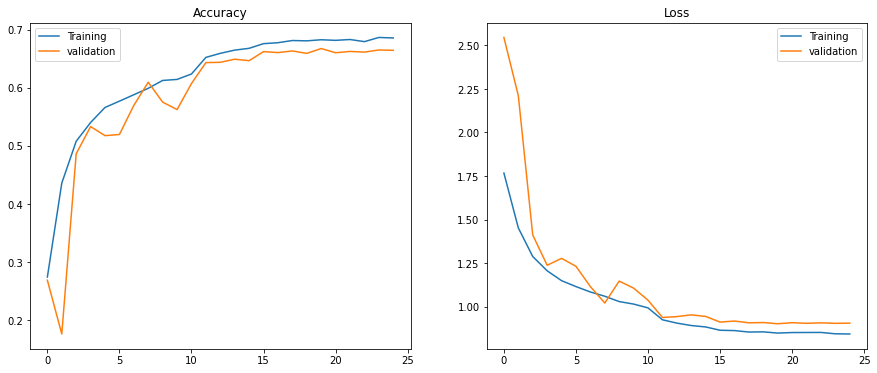

In [46]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['accuracy'],label = 'Training')
plt.plot(history.epoch,history.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['loss'],label = 'Training')
plt.plot(history.epoch,history.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

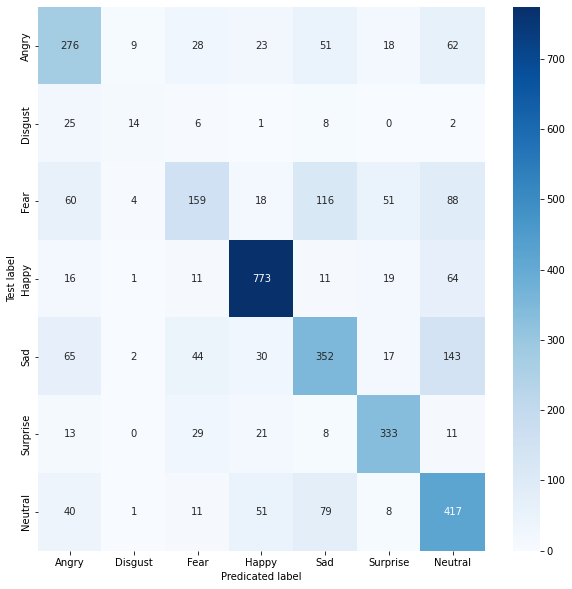

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results = model.predict(flow_test_gen)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 혼동행렬만들기
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(test_labels, axis=-1), np.argmax(results, axis=-1))        # matrix(테스트, 예측값)

cm_plot = sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=labels, yticklabels=labels)
cm_plot.set_xlabel('Predicated label')
cm_plot.set_ylabel('Test label')

plt.show()

In [48]:
## 테스트 이미지로 예측 결과 확인

pred_test_image_labels = model.predict(flow_test_gen)

pred_test_labels = []
for i in pred_test_image_labels:
  pred_test_labels.append(i.argmax())

pred_test = pd.DataFrame(pred_test_labels, columns=["emotion"])

Text(0.5, 1.0, 'Pred')

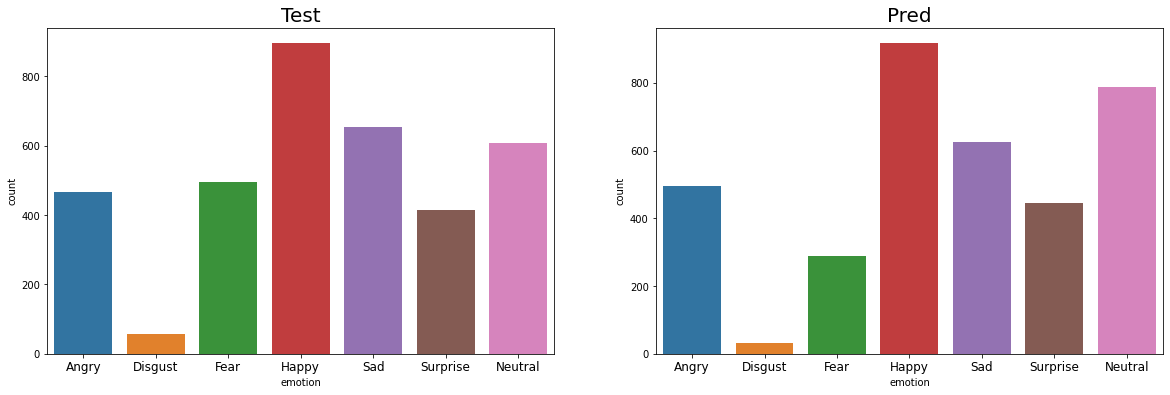

In [49]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
ax2 = sns.countplot(data = data[data[' Usage'] == 'PublicTest'], x = 'emotion')
ax2.set_xticklabels(names, size = 12)
ax2.set_title('Test', size = 20)

plt.subplot(1, 2, 2)
ax1 = sns.countplot(data = pred_test, x = 'emotion')
ax1.set_xticklabels(names, size = 12)
ax1.set_title('Pred', size = 20)

In [ ]:
model.save('2_loss:{0:.3f}-accuracy:{1:.3f}.h5'.format(model.evaluate(flow_test_gen)[0], model.evaluate(flow_test_gen)[1]))